In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
with open(r'.\Reviews_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

y_train = keras.utils.to_categorical(y_train-1, num_classes=5)
y_val = keras.utils.to_categorical(y_val-1, num_classes=5)
y_test = keras.utils.to_categorical(y_test-1, num_classes=5)

with open(r'.\embeddingMatrix_Reviews.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_REVIEW_LEN = 250 # maximum words in a review
num_classes = 5

In [3]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True)

model = keras.Sequential()
model.add(embedding_layer)
model.add(keras.layers.GlobalAveragePooling1D())

model.add(layers.Dense(units=96, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(units=96, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(units=96, activation='relu', kernel_initializer='he_uniform'))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
NUM_EPOCHS = 4
BATCH_SIZE = 128
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/4
771/771 [==============================] - 7s 6ms/step - loss: 1.2510 - accuracy: 0.4514 - val_loss: 1.1595 - val_accuracy: 0.5110
Epoch 2/4
771/771 [==============================] - 4s 6ms/step - loss: 1.0731 - accuracy: 0.5493 - val_loss: 1.1277 - val_accuracy: 0.5228
Epoch 3/4
771/771 [==============================] - 4s 6ms/step - loss: 0.9882 - accuracy: 0.5950 - val_loss: 1.1002 - val_accuracy: 0.5520
Epoch 4/4
771/771 [==============================] - 4s 6ms/step - loss: 0.8933 - accuracy: 0.6411 - val_loss: 1.1100 - val_accuracy: 0.5615


In [5]:
score = model.evaluate(X_val, y_val, verbose=1)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

771/771 [==============================] - 2s 2ms/step - loss: 1.1100 - accuracy: 0.5615
Validation loss:  1.1100165843963623
Validation accuracy:  0.5614604353904724


In [6]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

680/680 [==============================] - 1s 1ms/step
[[0.65333939 0.18293432 0.06757194 0.03103885 0.03324698]
 [0.19082235 0.49846532 0.1781442  0.06651182 0.04317789]
 [0.08518855 0.21240025 0.5347559  0.21431588 0.06282383]
 [0.03680145 0.06691222 0.16682832 0.47909628 0.2294905 ]
 [0.03384825 0.03928791 0.05269964 0.20903716 0.63126079]]


In [7]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('FNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

FNN accuracy is 55.90%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4
0  2876   894   209   147   154
1   840  2436   551   315   200
2   375  1038  1654  1015   291
3   162   327   516  2269  1063
4   149   192   163   990  2924
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      4280
           1       0.50      0.56      0.53      4342
           2       0.53      0.38      0.44      4373
           3       0.48      0.52      0.50      4337
           4       0.63      0.66      0.65      4418

    accuracy                           0.56     21750
   macro avg       0.56      0.56      0.56     21750
weighted avg       0.56      0.56      0.56     21750



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

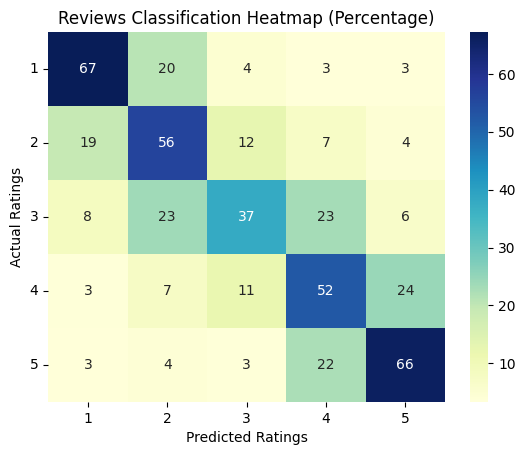

In [9]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("Reviews Classification Heatmap (Percentage)")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [10]:
from tensorflow.keras.models import load_model
import os

# Save the model
model_save_path = 'SavedModels/FNN_BestModel.h5'
model.save(model_save_path)

In [11]:
# Load the model
loaded_model = load_model(model_save_path)
score2 = loaded_model.evaluate(X_val, y_val, verbose=1)
print("Validation loss: ", score2[0])
print("Validation accuracy: ", score2[1])

771/771 [==============================] - 2s 2ms/step - loss: 1.1100 - accuracy: 0.5615
Validation loss:  1.1100165843963623
Validation accuracy:  0.5614604353904724
